In [13]:
using LinearAlgebra
using Plots
using LaTeXStrings #Latex Syntax for Plotting
using DelimitedFiles
using ITensors
using ITensors.HDF5
# ITensors.compile()

$$ H = -J\sum_{j = 1}^{N - 1}( b^{\dagger}_{j}b_{j+1} + h.c.)+\frac{U}{2} \sum_{j = 1}^{N} n_{j}(n_{j} - 1)$$

**Exact Diagonalization:**

In [2]:
function Create_Annihilation_Creation_Operators(N)
    # N is the Number of Bosons. Note: Creation is b† and annihilation is b.
    
    Creation = zeros(N+1, N+1) 
    for i=1:N
        Creation[i+1,i] = sqrt(i)
    end
    Annihilation = Adjoint(Creation)
    return Creation, Annihilation
end

function Enlarge_Matrix_site_j(j, N, matrix)
    # I⊗...⊗I⊗M⊗I...⊗I

    Identity = zeros(size(matrix))
    for i=1:size(matrix)[1]
        Identity[i,i] = 1
    end
    
    M = Identity
    
    if j == 1
        M = matrix
    end    
    
    for i=2:N 
        if i == j
        M = kron(M, matrix)
        else
        M = kron(M, Identity)        
        end
    end

    return M
end

function Enlarge_Matrix_i_Matrix_j(i,j,N, matrix_i, matrix_j)
    # I⊗...⊗I⊗M_i⊗I...⊗I⊗M_j⊗I⊗I...⊗I

    Identity = zeros(size(matrix_i))
    for i=1:size(matrix_i)[1]
        Identity[i,i] = 1
    end

    M = Identity

    
    if j == 1
        M = matrix_j
    end    

    if i == 1
        M = matrix_i
    end   
    
    for k=2:N 
        if k == j
        M = kron(M, matrix_j)
        elseif k == i
        M = kron(M, matrix_i)
        else
        M = kron(M, Identity)        
        end
    end

    return M
end

Enlarge_Matrix_i_Matrix_j (generic function with 1 method)

**Test 0: Definition of Creation and Annihilation Operators**

In [3]:
Creation, Annihilation = Create_Annihilation_Creation_Operators(3)
Identity = zeros(4,4)
for i=1:4
    Identity[i,i] = 1
end
kron(Identity,Creation) == Enlarge_Matrix_site_j(2,2,Creation)
kron(Identity,Creation, Annihilation) == Enlarge_Matrix_i_Matrix_j(2,3,3,Creation, Annihilation)

true

In [4]:
Creation

4×4 Matrix{Float64}:
 0.0  0.0      0.0      0.0
 1.0  0.0      0.0      0.0
 0.0  1.41421  0.0      0.0
 0.0  0.0      1.73205  0.0

In [3]:
function Build_ED_Bose_Hubbard_Hamiltonian(N_Bosons, L_Chain, J, U)
    # H = ∑ J(I⊗...⊗I...⊗I⊗bdag⊗b⊗I⊗...I⊗...⊗I + h.c.) +0.5*U(I⊗...⊗I...⊗I⊗n⊗n⊗I⊗...I⊗...⊗I - ⊗...⊗I⊗n⊗I⊗I...⊗I)

    H = zeros((N_Bosons+1)^L_Chain, (N_Bosons+1)^L_Chain)

    Creation, Annihilation = Create_Annihilation_Creation_Operators(N_Bosons)
    Particle_Number_Op = Creation*Annihilation

    for i=1:L_Chain-1
        j = i + 1 #nearest neighbor in 1D. Let's consider just OBC
        BdagB_Term = Enlarge_Matrix_i_Matrix_j(i,j,L_Chain, Creation, Annihilation)
        BBdag_Term = Enlarge_Matrix_i_Matrix_j(i,j,L_Chain, Annihilation, Creation)
        H = H -J*(BdagB_Term + BBdag_Term)
    end

    for i=1:L_Chain
        nini_Term =  Enlarge_Matrix_site_j(i, L_Chain, Particle_Number_Op*Particle_Number_Op)
        ni_Term = Enlarge_Matrix_site_j(i, L_Chain, Particle_Number_Op)
        H = H + 0.5*U*(nini_Term - ni_Term)
    end    

    return H
end

function Time_Evolution_Operator_ED(t, H)
    #|Ψ(t)> = exp(-itH)|Ψ(0)>

    return U = exp(-1im*t*H)   
end

Time_Evolution_Operator_ED (generic function with 1 method)

**Tensor Networks:**

In [5]:
function Build_MPO_Bose_Hubbard_Hamiltonian(N_Bosons, L_Chain, J, U, sites = false)
    # H = ∑ J(I⊗...⊗I...⊗I⊗bdag⊗b⊗I⊗...I⊗...⊗I + h.c.) +0.5*U(I⊗...⊗I...⊗I⊗n⊗n⊗I⊗...I⊗...⊗I - ⊗...⊗I⊗n⊗I⊗I...⊗I)

    if sites == false 
        sites = siteinds("Qudit",L_Chain, dim = N_Bosons + 1) #extra parameter: conserve_qns = true  
    end    
    # Input the operator terms 
    
    os = OpSum() 
    for i=1:L_Chain-1
        os += -J,"A",i,"Adag",i+1 
        os += -J,"Adag",i,"A",i+1 
    end 

    for i=1:L_Chain
        os += 0.5*U,"N * N",i
        os += -0.5*U,"N",i
    end 
    
    # Convert these terms to an MPO 
    H = MPO(os,sites)
    return H, sites
end

function TEBD_Time_Evolution_Expected_Value_Correlation(t, Psi_0, N_Bosons, L_Chain, J, U, site_i_corr = 1,  site_j_corr = 2)
    #|Ψ(t)> = exp(-itH)|Ψ(0)> #Main Function

    N = length(Psi_0)
    
    cutoff = 1E-8
    
    dt = 0.01
    
    maxdim = 40 #Each that apply is executed an SVD is also executed, maxdim is the maximum of the dimension that we will use from the SVD.
    # maxdim = 200 #Each that apply is executed an SVD is also executed, maxdim is the maximum of the dimension that we will use from the SVD.
    
    s = siteinds(Psi_0)
    
    # Make gates (1,2),(2,3),(3,4),...
    Evolution_Gates = ITensor[]    

    for j in 1:(N - 1)
    
        s1 = s[j]
        s2 = s[j + 1]

        hj = -J*op("A", s1)*op("Adag", s2) -J*op("Adag", s1)*op("A", s2) 
        hj = hj + 0.5*U*op("N * N", s1)*op("Id", s2) -0.5*U*op("N", s1)*op("Id", s2)
    
        if j == N-1
            hj = hj + 0.5*U*op("Id", s1)*op("N * N", s2) -0.5*U*op("Id", s1)*op("N", s2)
        end        
        
        push!(Evolution_Gates, exp(-im * dt/ 2 * hj))
    
    end

    append!(Evolution_Gates, reverse(Evolution_Gates))

    Correlation_Values = [real(correlation_matrix(Psi_0,"Adag","A")[site_i_corr,site_j_corr])] 
    Times = [0.0]
    
    Psi_t = Psi_0    
        
    for time in dt:dt:t
        Psi_t = apply(Evolution_Gates, Psi_t; cutoff, maxdim)
        normalize!(Psi_t)

        append!(Times, time)
        append!(Correlation_Values, real(correlation_matrix(Psi_t,"Adag","A")[site_i_corr,site_j_corr]))
    end
    
    return Correlation_Values, Times
end

function TEBD_Time_Evolution_Expected_Value_Correlation_N64(t, Psi_0, N_Bosons, L_Chain, J, U)
    #|Ψ(t)> = exp(-itH)|Ψ(0)> #Simplified Function for N = 64

    N = length(Psi_0)
    
    cutoff = 1E-8
    
    # dt = 0.01
    dt = 0.025
    
    maxdim = 40 #Each that apply is executed an SVD is also executed, maxdim is the maximum of the dimension that we will use from the SVD.
    # maxdim = 200 #Each that apply is executed an SVD is also executed, maxdim is the maximum of the dimension that we will use from the SVD.
      
    s = siteinds(Psi_0)
    
    # Make gates (1,2),(2,3),(3,4),...
    Evolution_Gates = ITensor[]    

    for j in 1:(N - 1)
    
        s1 = s[j]
        s2 = s[j + 1]

        hj = -J*op("A", s1)*op("Adag", s2) -J*op("Adag", s1)*op("A", s2) 
        hj = hj + 0.5*U*op("N * N", s1)*op("Id", s2) -0.5*U*op("N", s1)*op("Id", s2)
    
        if j == N-1
            hj = hj + 0.5*U*op("Id", s1)*op("N * N", s2) -0.5*U*op("Id", s1)*op("N", s2)
        end        
        
        push!(Evolution_Gates, exp(-im * dt/ 2 * hj))
    
    end

    append!(Evolution_Gates, reverse(Evolution_Gates))

    Correlation_Values1 = [real(correlation_matrix(Psi_0,"Adag","A")[1,2])] #Since site 1
    Correlation_Values2 = [real(correlation_matrix(Psi_0,"Adag","A")[32,33])] #Since center
    Times = [0.0]
    
    Psi_t = Psi_0    
        
    for time in dt:dt:t
        Psi_t = apply(Evolution_Gates, Psi_t; cutoff, maxdim)
        normalize!(Psi_t)

        append!(Times, time)
        append!(Correlation_Values1, real(correlation_matrix(Psi_t,"Adag","A")[1,2]))
        append!(Correlation_Values2, real(correlation_matrix(Psi_t,"Adag","A")[32,33]))
    end
    
    return Correlation_Values1, Correlation_Values2, Times
end

#General Functions. Still in process:

function determine_sites_with_distance_from_center(N, distance)

    Center = round(N/2)
    i = Center 
    j = Center
        
    for k = 1:N-1
        Center = round(N/2)
        if k % 2 != 0
            i = i 
            j = j + 1
        else
            i = i - 1
            j = j 
        end

        if abs(i-j) == distance
            return trunc(Int,i), trunc(Int,j)
        end
    end
end

function TEBD_Time_Evolution_Expected_Value_Correlation_distance(t, Psi_0, N_Bosons, L_Chain, J, U, site_inds, maximum_distance = 1)
    #|Ψ(t)> = exp(-itH)|Ψ(0)> 

    N = length(Psi_0)
    
    cutoff = 1E-8
    dt = 0.025
    maxdim = 40 #Each that apply is executed an SVD is also executed, maxdim is the maximum of the dimension that we will use from the SVD.
    
    s = site_inds
    
    # Make gates (1,2),(2,3),(3,4),...
    Evolution_Gates = ITensor[]    

    for j in 1:(N - 1)
    
        s1 = s[j]
        s2 = s[j + 1]

        hj = -J*op("A", s1)*op("Adag", s2) -J*op("Adag", s1)*op("A", s2) 
        hj = hj + 0.5*U*op("N * N", s1)*op("Id", s2) -0.5*U*op("N", s1)*op("Id", s2)
    
        if j == N-1
            hj = hj + 0.5*U*op("Id", s1)*op("N * N", s2) -0.5*U*op("Id", s1)*op("N", s2)
        end        
        
        push!(Evolution_Gates, exp(-im * dt/ 2 * hj))
    
    end

    append!(Evolution_Gates, reverse(Evolution_Gates))

    Correlation_Values_Since_Site_1 =  zeros((length(0:dt:t), maximum_distance))
    Correlation_Values_Since_Site_Center =  zeros((length(0:dt:t), maximum_distance))

    Correlation_Matrix = correlation_matrix(Psi_0,"Adag","A")

    for distance=1:maximum_distance
        Correlation_Values_Since_Site_1[1, trunc(Int,distance)] =  real(Correlation_Matrix[1,trunc(Int,1 + distance)]) #Measuring distance since site 1.
        println(trunc(Int,1 + distance))
        
        i,j = determine_sites_with_distance_from_center(N, distance) #Measuring distance since center site.
        Correlation_Values_Since_Site_Center[1,trunc(Int,distance)] = real(Correlation_Matrix[i,j])
    end

    Times = [0.0]
    
    Psi_t = Psi_0    
        
    for time in dt:dt:t
        Psi_t = apply(Evolution_Gates, Psi_t; cutoff, maxdim)
        normalize!(Psi_t)

        Correlation_Matrix = correlation_matrix(Psi_t,"Adag","A")

        for distance=1:maximum_distance  #Measuring distance since center site.
            Correlation_Values_Since_Site_1[trunc(Int, time/dt) + 1, trunc(Int,distance)] =  real(Correlation_Matrix[1,trunc(Int, 1 + distance)]) #Measuring distance since site 1.

            i,j = determine_sites_with_distance_from_center(N, distance) #Measuring distance since center site.
            Correlation_Values_Since_Site_Center[trunc(Int, time/dt) + 1,trunc(Int,distance)] = real(Correlation_Matrix[i,j])
        end
            
        append!(Times, time)

    end

    return Correlation_Values_Since_Site_Center, Correlation_Values_Since_Site_1, Times
end

TEBD_Time_Evolution_Expected_Value_Correlation_distance (generic function with 2 methods)

**Test 1: Determination of EigenValues.**

In [6]:
#ED
H = Build_ED_Bose_Hubbard_Hamiltonian(3, 6, 1, 1)
Eigenvalues = eigen(H).values
print(Eigenvalues[1], Eigenvalues[2], Eigenvalues[3])

-9.48479861742051-9.355368957128752-9.276847906537574

In [7]:
#Itensor
H_MPO, sites = Build_MPO_Bose_Hubbard_Hamiltonian(3,6,1,1)

nsweeps = 10
maxdim = [10,20,100,200,200] #maxdim - integer or array of integers specifying the maximum size allowed for the bond dimension or rank of the MPS being optimized
cutoff = [1E-10] #maxdim - integer or array of integers specifying the maximum size allowed for the bond dimension or rank of the MPS being optimized

energy_ground_state, psi_ground_state = dmrg(H_MPO,randomMPS(sites,4); nsweeps, maxdim, cutoff, outputlevel = 0) #randomMPS(sites,4) is the start point. Is a random MPS with bond dimension = number of bosons + 1
energy_1_excited_state, psi_1_excited_state = dmrg(H_MPO,[psi_ground_state], randomMPS(sites,4); nsweeps, maxdim, cutoff, outputlevel = 0) 
energy_2_excited_state, psi_2_excited_state = dmrg(H_MPO,[psi_ground_state, psi_1_excited_state], randomMPS(sites,4); nsweeps, maxdim, cutoff, outputlevel = 0) 

println(energy_ground_state, energy_1_excited_state, energy_2_excited_state) #Using ITensors

# ? randomMPS #Important if we want to include the conservation of nqs

-9.484798616389856-9.355367859123719-9.276848808183951


**Test 2: Quantum Quench with similar parameters of Figure 1.**

In [8]:
N_Bosons = 3 #4
L_Chain = 6 #Maximum with 4 Bosons because 5^6 < 2^14.
J = 1
Ui = 2*J
Uf = 40*J

#ED

Hi = Build_ED_Bose_Hubbard_Hamiltonian(N_Bosons, L_Chain, J, Ui)
Hf = Build_ED_Bose_Hubbard_Hamiltonian(N_Bosons, L_Chain, J, Uf)
#3 minutes to here.

Creation, Annihilation = Create_Annihilation_Creation_Operators(N_Bosons)
Correlation_Operator = Enlarge_Matrix_i_Matrix_j(1, 2, L_Chain, Creation, Annihilation) #Since site 1
# Correlation_Operator = Enlarge_Matrix_i_Matrix_j(3, 4, L_Chain, Creation, Annihilation) #Since center

lambda_0 = eigen(Hi).values[1] 
println(lambda_0)
Psi_0 = eigen(Hi).vectors[:,1] #16 min for this line

Times_ED = [0.0]
Correlations_ED = [Adjoint(Psi_0)*Correlation_Operator*Psi_0]

dt = 0.01
U = Time_Evolution_Operator_ED(dt, Hf)
Psi_t = Psi_0

for i=1:200
    Psi_t = U*Psi_t
    Correlation = Adjoint(Psi_t)*Correlation_Operator*Psi_t
    append!(Correlations_ED, Correlation.re)
    append!(Times_ED, dt*i)
end

-6.683600379728498


In [9]:
#ITensor.

N_Bosons = 3 #4
L_Chain = 6 #Maximum with 4 Bosons because 5^6 < 2^14.
J = 1
Ui = 2*J
Uf = 40*J

Hi_MPO, sites = Build_MPO_Bose_Hubbard_Hamiltonian(N_Bosons, L_Chain, J, Ui)

nsweeps = 100
maxdim = [200] #maxdim - integer or array of integers specifying the maximum size allowed for the bond dimension or rank of the MPS being optimized
cutoff = [1E-10] #maxdim - integer or array of integers specifying the maximum size allowed for the bond dimension or rank of the MPS being optimized

DMRG_observer = DMRGObserver(;energy_tol=10e-8, minsweeps=10, energy_type=Float64)
energy_ground_state, psi_ground_state = dmrg(Hi_MPO,randomMPS(sites,N_Bosons+1); nsweeps, maxdim, cutoff, observer = DMRG_observer) #randomMPS(sites,4) is the start point. Is a random MPS with bond dimension = number of bosons + 1

After sweep 1 energy=-6.500657447318372  maxlinkdim=57 maxerr=9.10E-11 time=0.181
After sweep 2 energy=-6.649591730299148  maxlinkdim=59 maxerr=8.58E-11 time=0.282
After sweep 3 energy=-6.665235067681778  maxlinkdim=55 maxerr=8.55E-11 time=0.248
After sweep 4 energy=-6.668506171059153  maxlinkdim=52 maxerr=8.92E-11 time=0.160
After sweep 5 energy=-6.670092242047891  maxlinkdim=51 maxerr=8.72E-11 time=0.218
After sweep 6 energy=-6.6714369991608615  maxlinkdim=50 maxerr=8.93E-11 time=0.180
After sweep 7 energy=-6.672712337521106  maxlinkdim=50 maxerr=8.93E-11 time=0.171
After sweep 8 energy=-6.673911161430381  maxlinkdim=50 maxerr=6.98E-11 time=0.178
After sweep 9 energy=-6.675035027542754  maxlinkdim=50 maxerr=9.58E-11 time=0.205
After sweep 10 energy=-6.67607270577875  maxlinkdim=50 maxerr=7.31E-11 time=0.173
After sweep 11 energy=-6.677038452403048  maxlinkdim=50 maxerr=6.55E-11 time=0.178
After sweep 12 energy=-6.677937986346672  maxlinkdim=50 maxerr=6.26E-11 time=0.161
After sweep 1

(-6.683600371957554, MPS
[1] ((dim=4|id=354|"Link,l=1"), (dim=4|id=773|"Qudit,Site,n=1"))
[2] ((dim=16|id=891|"Link,l=2"), (dim=4|id=573|"Qudit,Site,n=2"), (dim=4|id=354|"Link,l=1"))
[3] ((dim=4|id=725|"Qudit,Site,n=3"), (dim=30|id=868|"Link,l=3"), (dim=16|id=891|"Link,l=2"))
[4] ((dim=4|id=508|"Qudit,Site,n=4"), (dim=16|id=68|"Link,l=4"), (dim=30|id=868|"Link,l=3"))
[5] ((dim=4|id=703|"Qudit,Site,n=5"), (dim=4|id=134|"Link,l=5"), (dim=16|id=68|"Link,l=4"))
[6] ((dim=4|id=309|"Qudit,Site,n=6"), (dim=4|id=134|"Link,l=5"))
)

In [10]:
Correlations_TEBD, Times_TEBD = TEBD_Time_Evolution_Expected_Value_Correlation(2,  psi_ground_state, N_Bosons, L_Chain, J, Uf, 1, 2)

([1.003623715112483, 0.9199283909831827, 0.7033069270985702, 0.4374349615264789, 0.2091233474961651, 0.06566447841493725, 0.0012128384335902162, -0.022830890212064667, -0.040284366952706076, -0.051455490588737635  …  0.2771616981430391, 0.23748534100054375, 0.20954893126286622, 0.2014174988367042, 0.2226427187340977, 0.2777364958464396, 0.3605045233514237, 0.45390920647251587, 0.5359537842113046, 0.5878235983080508], [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09  …  1.91, 1.92, 1.93, 1.94, 1.95, 1.96, 1.97, 1.98, 1.99, 2.0])

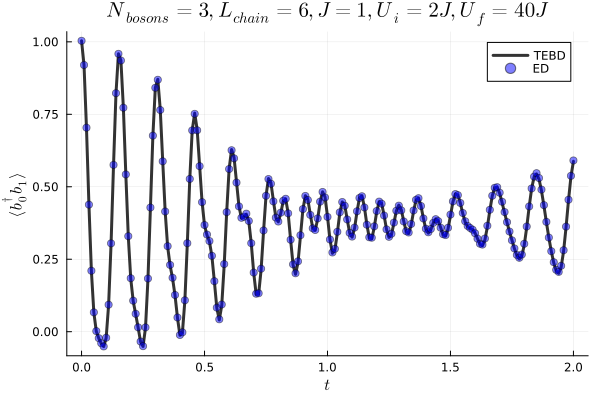

In [11]:
plot(Times_TEBD, Correlations_TEBD, label = "TEBD", color ="black", linewidth=3, alpha=0.8)
scatter!(Times_ED, Correlations_ED, label = "ED", color ="blue", alpha=0.5)

xlabel!(L"t")
ylabel!(L"\langle b^{\dagger}_{0} b_{1} \rangle")
title!(L"N_{bosons} = 3, L_{chain} = 6, J = 1, U_{i} = 2J, U_{f} = 40J")

**Figure 1.**

In [13]:
#Quantum Quench of Figure 1.

N_Bosons = 9
L_Chain = 64 
J = 1
Ui = 2*J
Uf = 40*J

Hi_MPO, sites = Build_MPO_Bose_Hubbard_Hamiltonian(N_Bosons, L_Chain, J, Ui)

nsweeps = 200
maxdim = [10,20,100,100,100,100,150,200,200,200,300] #maxdim - integer or array of integers specifying the maximum size allowed for the bond dimension or rank of the MPS being optimized
cutoff = [1E-10] 

DMRG_observer = DMRGObserver(;energy_tol=10e-7, minsweeps=10, energy_type=Float64)
energy_ground_state, psi_ground_state = dmrg(Hi_MPO,randomMPS(sites,N_Bosons+1); nsweeps, maxdim, cutoff, observer = DMRG_observer) #randomMPS(sites,4) is the start point. Is a random MPS with bond dimension = number of bosons + 1

After sweep 1 energy=-54.76391050770015  maxlinkdim=10 maxerr=2.30E-02 time=3.689
After sweep 2 energy=-78.05473036858035  maxlinkdim=20 maxerr=7.74E-05 time=9.020
After sweep 3 energy=-80.19504282023729  maxlinkdim=72 maxerr=9.99E-11 time=23.963
After sweep 4 energy=-81.35473473156684  maxlinkdim=77 maxerr=9.94E-11 time=27.414
After sweep 5 energy=-82.13898315116438  maxlinkdim=70 maxerr=9.99E-11 time=24.995
After sweep 6 energy=-82.757289775326  maxlinkdim=66 maxerr=9.97E-11 time=21.863
After sweep 7 energy=-83.31973216737407  maxlinkdim=63 maxerr=9.95E-11 time=20.610
After sweep 8 energy=-83.8640522305493  maxlinkdim=61 maxerr=1.00E-10 time=19.714
After sweep 9 energy=-84.58156084809161  maxlinkdim=74 maxerr=9.84E-11 time=20.127
After sweep 10 energy=-85.1523960961306  maxlinkdim=90 maxerr=9.97E-11 time=22.360
After sweep 11 energy=-85.52092185514779  maxlinkdim=92 maxerr=9.97E-11 time=22.451
After sweep 12 energy=-85.81330101170337  maxlinkdim=75 maxerr=9.99E-11 time=20.142
After s

(-88.74991427996343, MPS
[1] ((dim=6|id=990|"Link,l=1"), (dim=10|id=740|"Qudit,Site,n=1"))
[2] ((dim=20|id=941|"Link,l=2"), (dim=10|id=568|"Qudit,Site,n=2"), (dim=6|id=990|"Link,l=1"))
[3] ((dim=10|id=700|"Qudit,Site,n=3"), (dim=41|id=766|"Link,l=3"), (dim=20|id=941|"Link,l=2"))
[4] ((dim=10|id=194|"Qudit,Site,n=4"), (dim=59|id=683|"Link,l=4"), (dim=41|id=766|"Link,l=3"))
[5] ((dim=10|id=342|"Qudit,Site,n=5"), (dim=66|id=823|"Link,l=5"), (dim=59|id=683|"Link,l=4"))
[6] ((dim=10|id=659|"Qudit,Site,n=6"), (dim=78|id=707|"Link,l=6"), (dim=66|id=823|"Link,l=5"))
[7] ((dim=10|id=330|"Qudit,Site,n=7"), (dim=84|id=383|"Link,l=7"), (dim=78|id=707|"Link,l=6"))
[8] ((dim=10|id=682|"Qudit,Site,n=8"), (dim=100|id=981|"Link,l=8"), (dim=84|id=383|"Link,l=7"))
[9] ((dim=10|id=718|"Qudit,Site,n=9"), (dim=109|id=725|"Link,l=9"), (dim=100|id=981|"Link,l=8"))
[10] ((dim=10|id=294|"Qudit,Site,n=10"), (dim=109|id=73|"Link,l=10"), (dim=109|id=725|"Link,l=9"))
[11] ((dim=10|id=771|"Qudit,Site,n=11"), (dim=11

**maxdim = 40. approximate time = 2 hours for t = 2.**

In [17]:
# Correlations_TEBD, Times_TEBD = TEBD_Time_Evolution_Expected_Value_Correlation(2,  psi_ground_state, N_Bosons, L_Chain, J, Uf, 1,2)

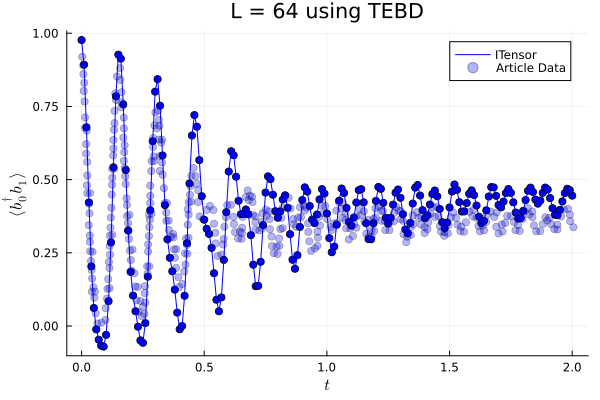

In [177]:
scatter(Times_TEBD, Correlations_TEBD, label = false, color = "blue")
plot!(Times_TEBD, Correlations_TEBD, label = "ITensor", color = "blue")

Figure1_Data = readdlm("txt_files/Hubbard_Fig 1.txt", ',', Float64)
scatter!(Figure1_Data[:,1], Figure1_Data[:,2], label = "Article Data", color = "blue", alpha = 0.3 )

xlabel!(L"t")
ylabel!(L"\langle b^{\dagger}_{0} b_{1} \rangle")
title!("L = 64 using TEBD")

In [9]:
# f = h5open("Ground_State_Figure1.h5","w")
# write(f,"psi",psi_ground_state)
# close(f)

**maxdim = 200. approximate time = 72000 seconds for t = 2.**

In [13]:
#Quantum Quench of Figure 1.

N_Bosons = 9
L_Chain = 64 
J = 1
Ui = 2*J
Uf = 40*J

f = h5open("Ground_State_Figure1.h5","r")
psi = read(f,"psi",MPS)
close(f)

In [17]:
Correlations_TEBD_1, Correlations_TEBD_2, Times_TEBD_1 = TEBD_Time_Evolution_Expected_Value_Correlation2(0.01,  psi, N_Bosons, L_Chain, J, Uf)

([0.9780473305515125, 0.8938492861214373], [1.1834878400416167, 1.069335328917145], [0.0, 0.01])

In [18]:
Correlations_TEBD_1, Correlations_TEBD_2, Times_TEBD_1 = TEBD_Time_Evolution_Expected_Value_Correlation2(2,  psi, N_Bosons, L_Chain, J, Uf)

([0.9780473305515125, 0.8938492861214373, 0.6795486489449001, 0.4223747095183479, 0.20375754758782794, 0.062102638613638295, -0.010570267709458745, -0.045372829151544225, -0.06567122704570251, -0.0690555143641259  …  0.4350761741090785, 0.3996663151263342, 0.37634519735015676, 0.37415121273373037, 0.3916822291920311, 0.4204660813782547, 0.4486272204339663, 0.4638848519160699, 0.45942330905515283, 0.44076664895615714], [1.1834878400416167, 1.069335328917145, 0.7933587356907816, 0.493444556107436, 0.2743423791946799, 0.1631755136275589, 0.12864934296296918, 0.12147858805889841, 0.10993873416047306, 0.0993867133847206  …  0.46229026951577273, 0.4462385519723108, 0.4445453970740672, 0.45816527848211136, 0.4775003402129828, 0.4902851157144517, 0.4903738402090881, 0.4805577777065739, 0.4685721449711246, 0.4615269178655141], [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09  …  1.91, 1.92, 1.93, 1.94, 1.95, 1.96, 1.97, 1.98, 1.99, 2.0])

In [19]:
# writedlm("Correlations_TEBD_1.txt", Correlations_TEBD_1)
# writedlm("Correlations_TEBD_2.txt", Correlations_TEBD_2)
# writedlm("Times_TEBD_1.txt", Times_TEBD_1)

# 72000 seconds - approx 20 hours.

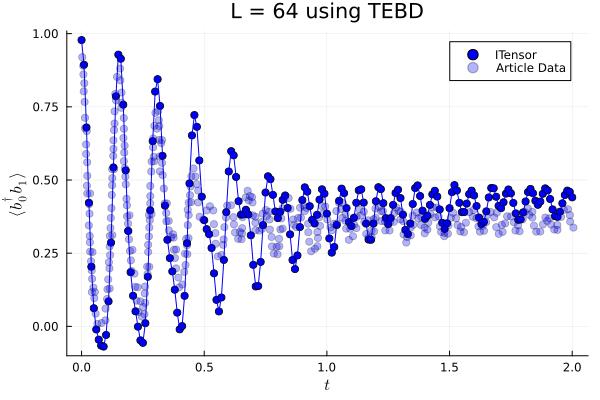

In [31]:
Correlations_TEBD_1 = readdlm("Correlations_TEBD_1.txt") #Distance since site 1
Times_TEBD_1 = readdlm("Times_TEBD_1.txt")

scatter(Times_TEBD_1, Correlations_TEBD_1, label = "ITensor ", color = "blue")
plot!(Times_TEBD_1, Correlations_TEBD_1, label = false, color = "blue")

Figure1_Data = readdlm("txt_files/Hubbard_Fig 1.txt", ',', Float64) #Article data
scatter!(Figure1_Data[:,1], Figure1_Data[:,2], label = "Article Data", color = "blue", alpha = 0.3 )

xlabel!(L"t")
ylabel!(L"\langle b^{\dagger}_{0} b_{1} \rangle")
title!("L = 64 using TEBD")

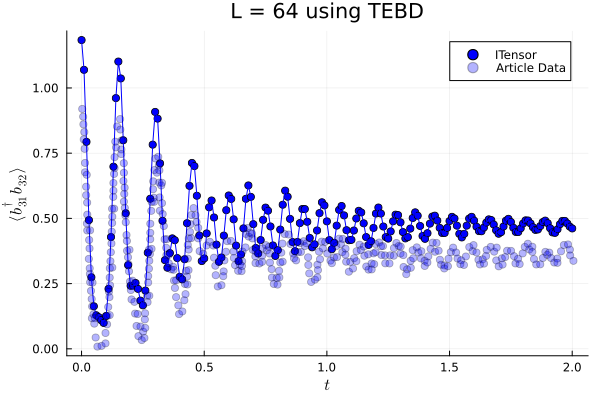

In [33]:
Correlations_TEBD_2 = readdlm("Correlations_TEBD_2.txt") #Distance since center
Times_TEBD_1 = readdlm("Times_TEBD_1.txt")

scatter(Times_TEBD_1, Correlations_TEBD_2, label = "ITensor ", color = "blue")
plot!(Times_TEBD_1, Correlations_TEBD_2, label = false, color = "blue")

Figure1_Data = readdlm("txt_files/Hubbard_Fig 1.txt", ',', Float64) #Article data
scatter!(Figure1_Data[:,1], Figure1_Data[:,2], label = "Article Data", color = "blue", alpha = 0.3)

xlabel!(L"t")
ylabel!(L"\langle b^{\dagger}_{31} b_{32} \rangle")
title!("L = 64 using TEBD")

In [17]:
#Let's try to improve the calculus of the ground state

#ITensor.

N_Bosons = 9
L_Chain = 64 
J = 1
Ui = 2*J
Uf = 40*J

f = h5open("Ground_State_Figure1.h5","r")
psi = read(f,"psi",MPS)
close(f)

Hi_MPO, sites = Build_MPO_Bose_Hubbard_Hamiltonian(N_Bosons, L_Chain, J, Ui, siteinds(psi))

inner(psi', Hi_MPO, psi) #Current ground state energy with 10e-7 tolerance

-88.74991428006602

In [ ]:
nsweeps = 200
maxdim = [300] #maxdim - integer or array of integers specifying the maximum size allowed for the bond dimension or rank of the MPS being optimized
cutoff = [1E-10] 

DMRG_observer = DMRGObserver(;energy_tol=10e-10, minsweeps=10, energy_type=Float64)
energy_ground_state, psi_ground_state = dmrg(Hi_MPO,psi; nsweeps, maxdim, cutoff, observer = DMRG_observer) #randomMPS(sites,4) is the start point. Is a random MPS with bond dimension = number of bosons + 1

**Fourier Transform:**

In [44]:
using FFTW

In [185]:
# t0 = 0.0             # Start time 
# fs = 1       # Sampling rate (Hz)
# tmax = 2.0        # End time       
# t = t0:1/fs:tmax;

# F = fftshift(fft(Correlations_TEBD))
# freqs = fftshift(fftfreq(length(Times_ED), fs))

# freq_domain = plot(freqs, abs.(F), legend = false, linewidth=3, alpha=1, color = "black") 

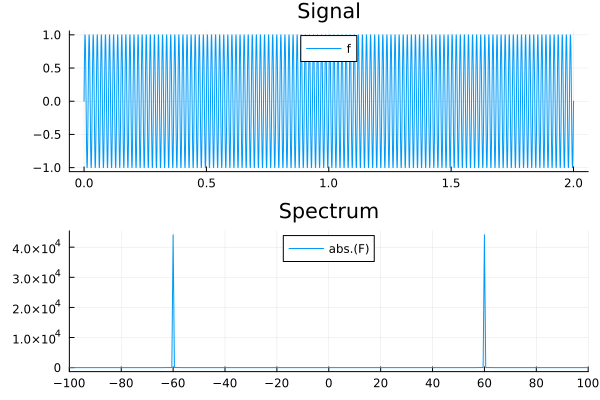

In [145]:
using FFTW
using Plots

t0 = 0              # Start time 
fs = 44100          # Sampling rate (Hz)
tmax = 2    # End time       

t = t0:1/fs:tmax;   
signal = sin.(2π * 60 .* t)

F = fftshift(fft(signal))
freqs = fftshift(fftfreq(length(t), fs))

# plots 
time_domain = plot(t, signal, title = "Signal", label='f',legend=:top)
freq_domain = plot(freqs, abs.(F), title = "Spectrum", xlim=(-100, +100), xticks=-100:20:100, label="abs.(F)",legend=:top) 
plot(time_domain, freq_domain, layout = (2,1))

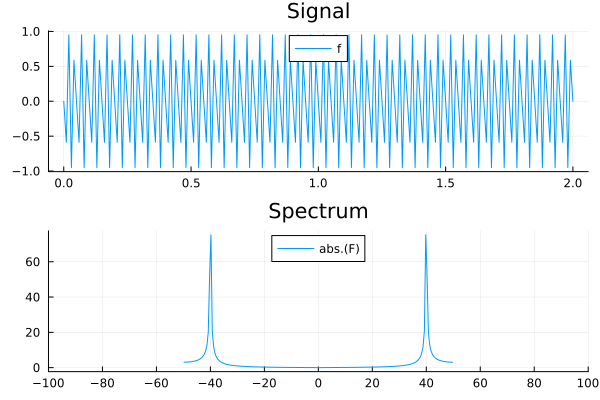

In [146]:
t = 0:0.01:2;   
signal = sin.(2π * 60 .* t)

F = fftshift(fft(signal))
freqs = fftshift(fftfreq(length(t), 1/0.01))

# plots 
time_domain = plot(t, signal, title = "Signal", label='f',legend=:top)
freq_domain = plot(freqs, abs.(F), title = "Spectrum", xlim=(-100, +100), xticks=-100:20:100, label="abs.(F)",legend=:top) 
plot(time_domain, freq_domain, layout = (2,1))